In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('Nile.xlsx')
df = df.rename(columns={'Unnamed: 0':'Year'})
df

,Year,Nile
0,1871,1120
1,1872,1160
2,1873,963
3,1874,1210
4,1875,1160
...,...,...
95,1966,746
96,1967,919
97,1968,718
98,1969,714


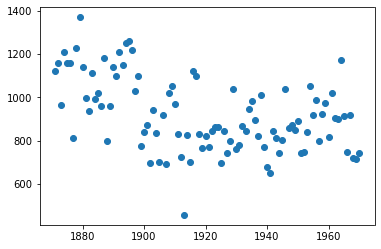

In [3]:
plt.scatter(df['Year'], df['Nile'])

In [4]:
def KF_LL(data, a_ini, P_ini, sig_e, sig_eta):
    a =  np.zeros(len(df))
    a[0] = a_ini

    v = np.zeros(len(df))
    v[0] = data[0] - a[0]

    P = np.zeros(len(df))
    P[0] = P_ini

    F = np.zeros(len(df))
    F[0] = P[0] + sig_e
    K = np.zeros(len(df))
    K[0] = P[0] / F[0]

    ## Ik heb de volgorde aangepast, zodat de t+1 en t bij allemaal overeenkomen
    for t in range(1, len(df)):
        a[t] = a[t-1] + K[t-1] * v[t-1]
        v[t] = data[t] - a[t]
        P[t] = K[t-1] * sig_e + sig_eta
        F[t] = P[t] + sig_e
        K[t] = P[t] / F[t]

    return (v, P, F, a, K)

data_nile = df['Nile']
years = df['Year']

a_ini = 0
P_ini = 10**7
sig_e = 15099
sig_eta = 1469.1

v, P, F, a, K = KF_LL(data_nile, a_ini, P_ini, sig_e, sig_eta)

#Confidence intervals
z = 1.645
ll_ci_lo = a - z*np.sqrt(P)
ll_ci_up = a + z*np.sqrt(P)

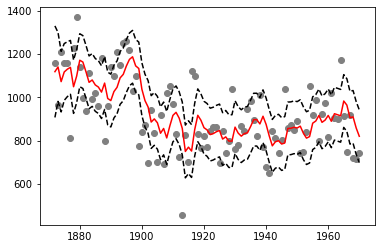

In [5]:
plt.scatter(df['Year'][1:], df['Nile'][1:], color ='grey')
plt.plot(years[1:], a[1:], color = 'red')
plt.plot(years[1:], ll_ci_lo[1:], linestyle='dashed', color = 'black')
plt.plot(years[1:], ll_ci_up[1:], linestyle='dashed', color = 'black')

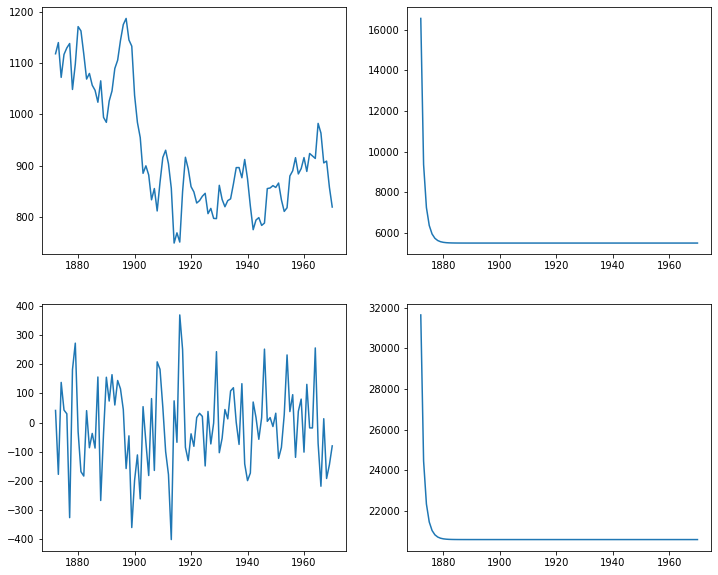

In [6]:
# fig_1_vals = pd.DataFrame([[v, P]])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))
ax1.plot(years[1:], a[1:])
ax2.plot(years[1:], P[1:])
ax2.ticklabel_format(style='plain')
ax3.plot(years[1:], v[1:])
ax4.plot(years[1:], F[1:])
ax4.ticklabel_format(style='plain')

In [7]:
def KS_LL(data, a_ini, P_ini, sig_e, sig_eta):

    v, P, F, a, K = KF_LL(data, a_ini, P_ini, sig_e, sig_eta)

    r =  np.zeros(len(df))
    r[-1] = 0

    N = np.zeros(len(df))
    N[-1] = 0
    
    a_hat = np.zeros(len(df))

    V = np.zeros(len(df))

    for t in range(len(df)-2, -1, -1):
        if data[t] == np.NaN:
            r[t] = r[t+1]
            N[t] = N[t+1]
        else:
            r[t] = F[t]**-1*v[t] + (1-K[t]) * r[t+1]
            N[t] = F[t]**-1 + (1-K[t])**2*N[t+1]

    for t in range(0, len(df)):
        a_hat[t] = a[t] + P[t] *r[t]
        V[t] = P[t] - P[t]**2*N[t]

    return (r, N, a_hat, V)

In [8]:
r, N, a_hat, V = KS_LL(data_nile, a_ini, P_ini, sig_e, sig_eta)

#Confidence intervals
ks_ci_lo = a_hat - z*np.sqrt(P)
ks_ci_up = a_hat + z*np.sqrt(P)

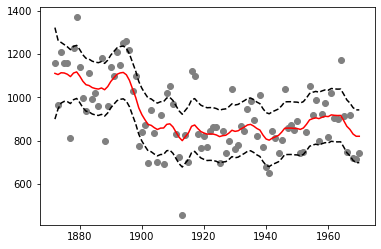

In [9]:
plt.scatter(df['Year'][1:], df['Nile'][1:], color ='grey')
plt.plot(years[1:], a_hat[1:], color = 'red')
plt.plot(years[1:], ks_ci_lo[1:], linestyle='dashed', color = 'black')
plt.plot(years[1:], ks_ci_up[1:], linestyle='dashed', color = 'black')

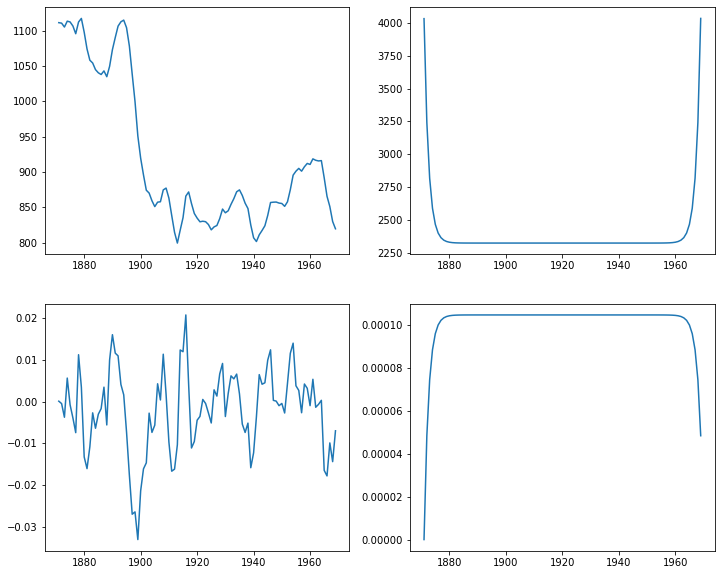

In [10]:
# fig_1_vals = pd.DataFrame([[v, P]])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))
ax1.plot(years[:-1], a_hat[:-1])
ax2.plot(years[:-1], V[:-1])
ax2.ticklabel_format(style='plain')
ax3.plot(years[:-1], r[:-1])
ax4.plot(years[:-1], N[:-1])
ax4.ticklabel_format(style='plain')

In [11]:
## Figuur 2.3.
e_hat = data_nile - a_hat
eta_hat = a_hat[1:] - a_hat[:-1]
D = F**-1 + K**2 * N
var_e = sig_e - sig_e**2 * D
var_eta = sig_eta - sig_eta**2 * N

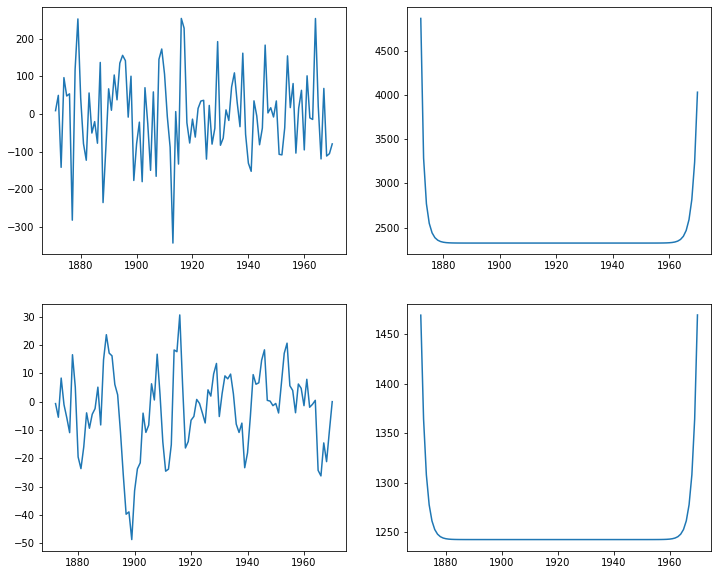

In [13]:
# fig_1_vals = pd.DataFrame([[v, P]])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))
ax1.plot(years, e_hat)
ax2.plot(years[1:], var_e[1:])
ax2.ticklabel_format(style='plain')
ax3.plot(years[1:], eta_hat)
ax4.plot(years, var_eta)
ax4.ticklabel_format(style='plain')